<a href="https://colab.research.google.com/github/AkaluTeklu/Deep-Reinforcement-learning/blob/main/Deep_Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The goal is to keep the pole balanced on top of the cart for as long as possible by moving the cart left and right such that the pole remains upright within a specific angle. In this work, deep reinforcement learning is implemented to train the cart pole system. In the training process, each episode terminates if one of the following conditions is met:


*   The cart displaces too much from the center.
*   The pole tilts too much.
*  The episode reaches the maximum number of steps per episode.

In [18]:
%%capture
!pip install -q swig

%pip install gym==0.25.2
%pip install -q gym[classic_control,box2d,atari]
!pip install pyglet pyvirtualdisplay

In [26]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import gym
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from collections import deque
from pyvirtualdisplay import Display
from IPython import display
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

This section describes a simple policy that allows an agent to move the cart by executing a sequence of 0 or 1 actions. In the event that the pole tilts to the left, the agent would push the cart to the left, and vice versa.

In [24]:
env = gym.make("CartPole-v1", render_mode="rgb_array")


In [25]:
def Simple_model(next_state):
    Pole_angle = next_state[2]
    return 0 if Pole_angle < 0 else 1

score = 0
episodes = 400
num_steps = 600

for episode in range(episodes):
    episode_rewards = 0
    next_state = env.reset(seed=episode)

    for i in range(num_steps):
        action = Simple_model(next_state)
        next_state, reward, done,_ = env.step(action)
        episode_rewards += reward
        env.render()
        #print(i, next_state, reward, done, truncated, info, action)
        if done:
            break

    score.append(episode_rewards)
    #print(f"Episode {episode}, score: {score}")
    #print(f"Reward: {episode_rewards}, Mean: {np.mean(score)}")



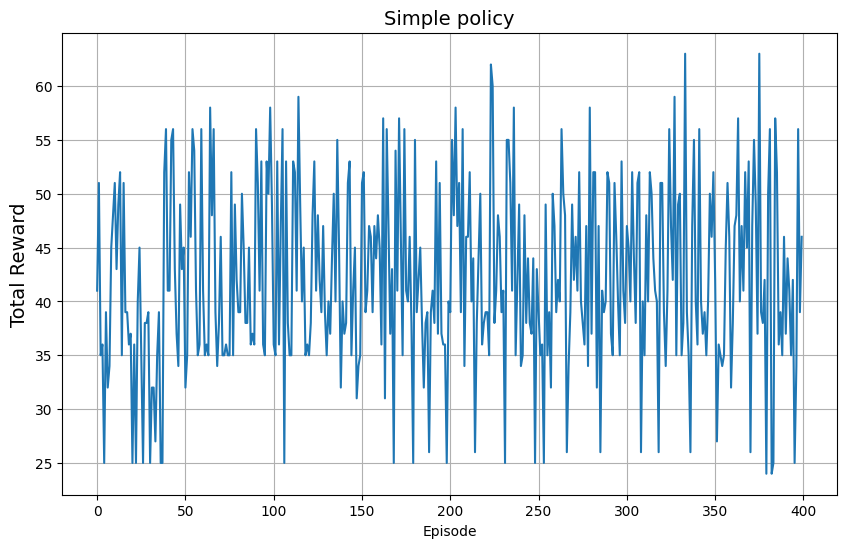

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(score)
plt.xlabel('Episode')
plt.ylabel('Total Reward', fontsize=14)
plt.title('Simple policy', fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
max(score)

63.0

As we can see this policy is not achieving the desired performance in the CartPole environment. It was expected to keep the pole upright within the predefined angle and position for 600 steps but unfortunetly, it ables to maintain the pole upright for only 63 steps.In other words, the maximum reward obtained after 400 episodes of training is only 63, which is considered quite low.

To improve the performance of the agent, a more advanced strategies like Deep Q Network should be implemented.

In [ ]:
import matplotlib.animation
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def create_animation(policy, num_episodes=5, n_max_steps=600, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

create_animation(Simple_model, num_episodes=5)

In [ ]:
# Create and display the animation
animation = create_animation(Simple_model)
from IPython.display import HTML
HTML(animation.to_jshtml())

## Deep Neural Network Policy

In this section, a neural network policy is designed to acquire the ability to map states to actions in a manner that maximizes expected cumulative reward over time.For this inverted pendulum, the state typically includes information such as the cart's position, cart's velocity, pole's angle, and pole's angular velocity. The DNN policy will take this state information as input and output probabilities for each possible action ( move left or move right) as given below.

In [ ]:
# Create Deep neural network model

def create_DQN_model(input_shape, num_actions):
    model = tf.keras.Sequential([
        layers.Dense(512, activation='relu', input_shape=input_shape),
        layers.Dense(256, activation='relu'),
        layers.Dense(64,  activation='relu'),

        layers.Dense(num_actions, activation='linear')
    ])

    return model

## Replay Buffer

The replay buffer is designed to retain historical experiences, and it trains the DNN policy by utilizing these stored experiences. This prevents the model from forgetting previous experiences, which could happen if new experiences continually overwrite them. It als allows for random sampling of experiences from replay buffer during training, which helps in stabilizing the training process, preventing the network from oscillating or diverging and promotes stability.


In [ ]:
from collections import deque

class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add_experience(self, experience):
        self.buffer.append(experience)

    def sample_batch(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)


## Agent Modeling

In this section, the Deep Q Network agent is modeled. The process involves implementing epsilon-greedy exploration, where the agent decides whether to explore new actions or exploit its current knowledge based on a specified exploration rate (epsilon). The Q-network is trained using experiences stored in the replay buffer, which helps stabilize and improve the learning process by breaking the temporal correlation between consecutive experiences. The epsilon-greedy strategy balances exploration and exploitation to enhance the agent's decision-making during training.

Note: The action with the highest projected Q-value is chosen based on the exploration rate (epsilon) to ensure that the environment is explored by the agent using this DQN as given below in the select_action function.


In [ ]:
class DQNAgent:

    def __init__(self, state_shape, num_actions, epsilon=1.0, epsilon_decay=0.98, min_epsilon=0.01, gamma=0.96):

        self.Q_model = create_DQN_model(state_shape, num_actions)
        self.target_model = create_DQN_model(state_shape, num_actions)
        self.replay_buffer = ReplayBuffer(buffer_size=10000)
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.gamma = gamma
        self.optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)

##################################################################################

    # Selecting the agent's action based on exploration rate

    def select_action(self, state):

        if np.random.rand() < self.epsilon:
            return np.random.choice(num_actions)

        else:
            Q_values = self.Q_model_model.predict(state.reshape(1, -1))
            return np.argmax(Q_values)

##########################################################################################


## Q-learning in DQNAgent

This process essentially trains the Q-network by minimizing the temporal difference error between the predicted Q-values and the target Q-values, helping the agent learn an optimal policy.The following events are happening in this stage:


*   Checks if the replay buffer has enough experiences to form batch(64)
*   Calculates the target Q-values for the batch using the target Q-network


*   Computes the Q-values for the batch using the current Q-network.
*   Defines a loss function based on the mean squared difference between the target and predicted Q-values.


*   Computes the gradients of the loss with respect to the Q-network parameters.
*  Updates the Q-network's parameters using adam optimizer

In [ ]:
def train_step(self, batch_size):
    if len(self.replay_buffer.buffer) < batch_size:
        return

    states, actions, rewards, next_states, dones = self.replay_buffer.sample_batch(batch_size)
    target_Q_values = rewards + self.gamma * np.amax(self.target_model.predict(next_states), axis=1) * (1 - dones)
    target_Q_values = target_Q_values.reshape(-1, 1)

    with tf.GradientTape() as tape:
        Q_values = self.Q_model(states)
        action_masks = tf.one_hot(actions, num_actions)
        selected_Q_values = tf.reduce_sum(action_masks * Q_values, axis=1, keepdims=True)
        loss = tf.reduce_mean(tf.square(target_Q_values - selected_Q_values))

    gradients = tape.gradient(loss, self.Q_model.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.Q_model.trainable_variables))

## Agent Training

In this stage, the agent interacts with the environment, collecting experiences that include states, actions, rewards, and next states. These experiences are stored in a replay buffer, and periodically, batches are sampled to train the DQN agent's Q-network, adjusting its parameters for improved performance. The target network is updated regularly, and the agent balances exploration and exploitation to refine its policy over time.

In [ ]:
if __name__ == "__main__":
    env = gym.make("CartPole-v1", render_mode='rgb_array')
    state_shape = env.observation_space.shape
    num_actions = env.action_space.n
    target_update_frequency = 10

    agent = DQNAgent(state_shape, num_actions)

    episode_rewards = []
    max_reward_episode = 0
    max_reward_step = 0
    max_reward = float('-inf')
    episodes=400
    num_steps=600

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for step in range(num_steps):
            action = agent.select_action(state)
            next_state, reward, done,truncated, info= env.step(action)
            total_reward += reward

            agent.replay_buffer.add_experience((state, action, reward, next_state, done))
            agent.train_step(batch_size=64)

            state = next_state

            if done:
                break

        episode_rewards.append(total_reward)
        print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

        if total_reward > max_reward:
            max_reward = total_reward
            max_reward_episode = episode + 1
            max_reward_step = step + 1

        if episode % target_update_frequency == 0:
            agent.target_model.set_weights(agent.Q_model.get_weights())

        agent.epsilon = max(agent.min_epsilon, agent.epsilon * agent.epsilon_decay)

    print(f"Maximum Reward: {max_reward} achieved in Episode: {max_reward_episode}, Step: {max_reward_step}")

## Evaluate the Model

In this stage, the trained DQN agent employs its learned policy to interact with the environment without further learning. This allows for the evaluation of the agent's performance in a previously unseen environment. The key objective is to assess how well the agent generalizes its learned policy to make decisions and achieve high rewards in novel scenarios.

In [ ]:
num_test_episodes = 5

test_results = agent.evaluate(env, nb_episodes=num_test_episodes, visualize=True)

average_reward = np.mean(test_results.history['episode_reward'])
print(f"Average reward over {num_test_episodes} test episodes: {average_reward}")
plt.figure(figsize=(10, 6))
plt.plot(test_results.history['episode_reward'])
plt.xlabel('Test Episode')
plt.ylabel('Total Reward')
plt.title('Test Process')
plt.show()

## Overall Model

In [27]:
def create_DNN_model(input_shape, num_actions):
    model = tf.keras.Sequential([
        layers.Dense(512, activation='relu', input_shape=input_shape),
        layers.Dense(256, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_actions, activation='linear')
    ])
    return model


class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add_experience(self, experience):
        self.buffer.append(experience)

    def sample_batch(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)


class DQNAgent:

    def __init__(self, state_shape, num_actions, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, gamma=0.99):

        self.Q_model = create_DNN_model(state_shape, num_actions)
        self.target_model = create_DNN_model(state_shape, num_actions)
        self.replay_buffer = ReplayBuffer(buffer_size=10000)
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.gamma = gamma
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)



    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(num_actions)
        Q_values = self.Q_model.predict(state.reshape(1, -1))
        return np.argmax(Q_values)



    def train_step(self, batch_size):
        if len(self.replay_buffer.buffer) < batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample_batch(batch_size)
        target_Q_values = rewards + self.gamma * np.amax(self.target_model.predict(next_states), axis=1) * (1 - dones)
        target_Q_values = target_Q_values.reshape(-1, 1)


        with tf.GradientTape() as tape:
            Q_values = self.Q_model(states)
            action_masks = tf.one_hot(actions, num_actions)
            selected_Q_values = tf.reduce_sum(action_masks * Q_values, axis=1, keepdims=True)
            loss = tf.reduce_mean(tf.square(target_Q_values - selected_Q_values))

        gradients = tape.gradient(loss, self.Q_model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.Q_model.trainable_variables))
    def save(self, file_path):
        self.Q_model.save(file_path)

    def load(self, file_path):
        self.Q_model = tf.keras.models.load_model(file_path)
        self.target_model = tf.keras.models.load_model(file_path)


if __name__ == "__main__":
    env = gym.make("CartPole-v1", render_mode='rgb_array')
    state_shape = env.observation_space.shape
    num_actions = env.action_space.n
    target_update_frequency = 10

    agent = DQNAgent(state_shape, num_actions)

    episode_rewards = []
    max_reward_episode = 0
    max_reward_step = 0
    max_reward = float('-inf')
    episodes=400
    num_steps=600
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for step in range(num_steps):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            agent.replay_buffer.add_experience((state, action, reward, next_state, done))
            agent.train_step(batch_size=64)

            state = next_state

            if done:
                break

        episode_rewards.append(total_reward)
        #print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

        if total_reward > max_reward:
            max_reward = total_reward
            max_reward_episode = episode + 1
            max_reward_step = step + 1

        if episode % target_update_frequency == 0:
            agent.target_model.set_weights(agent.Q_model.get_weights())

        agent.epsilon = max(agent.min_epsilon, agent.epsilon * agent.epsilon_decay)

    #print(f"Maximum Reward: {max_reward} achieved in Episode: {max_reward_episode}, Step: {max_reward_step}")
    agent.save("dqn_model.h5")


Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 10ms/step


In [ ]:
num_test_episodes = 5

test_results = agent.evaluate(env, nb_episodes=num_test_episodes, visualize=True)

average_reward = np.mean(test_results.history['episode_reward'])
print(f"Average reward over {num_test_episodes} test episodes: {average_reward}")
plt.figure(figsize=(10, 6))
plt.plot(test_results.history['episode_reward'])
plt.xlabel('Test Episode')
plt.ylabel('Total Reward')
plt.title('Test Process')
plt.show()

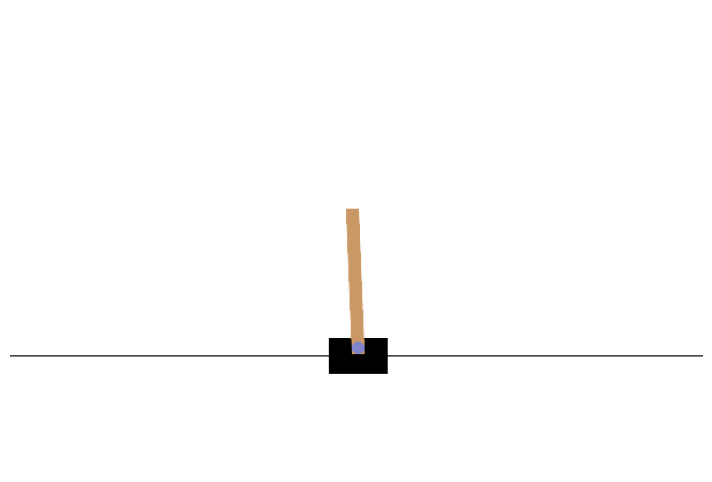

In [ ]:
from IPython.display import display, clear_output

env = gym.make("CartPole-v1")
obs = env.reset()
img = env.render(mode='rgb_array')
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
display(plt.gcf())
clear_output(wait=True)

env.close()



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


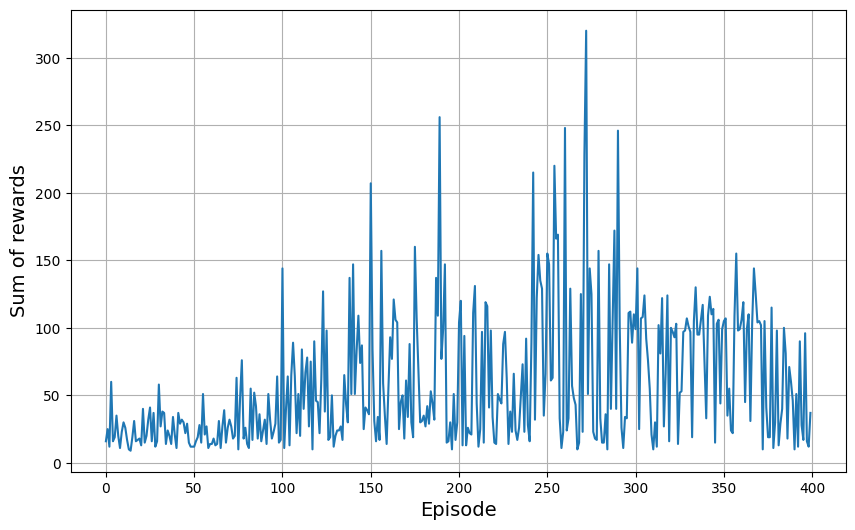

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()


Observing the graph, it is evident that the system successfully stabilizes the pole for 320 steps out of 600, showcasing significant improvement compared to the earlier version. However, further fine-tuning of the model is deemed necessary.

In [ ]:
import gym
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=50):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def create_animation(env, num_steps=600):
    frames = []
    next_step = env.reset()
    for _ in range(num_steps):
        frames.append(env.render(mode='rgb_array'))
        action = env.action_space.sample()
        next_step, reward, done, _ = env.step(action)
        if done:
            break
    env.close()
    return frames


env = gym.make("CartPole-v1")
animation_frames = create_animation(env, num_steps=600)
cartpole_animation = plot_animation(animation_frames)
display(HTML(cartpole_animation.to_jshtml()))


Challenge:

The limited computational resources currently constrain the number of steps per episode and the total number of episodes. Attempts to increase these parameters result in system crashes due to insufficient available RAM in the package.

Next step:
I will undertake the task of finely tuning the parameters.